Create a reduced basis for a simple sinusoid model

In [1]:
%matplotlib inline
import numpy as np
from misc import *
import matplotlib.pyplot as plt

from lalapps import pulsarpputils as pppu

Create the signal model:
$h(t) = \frac{h0}{2}\Big[\frac{1}{2}F_+ (1+\cos{}^2\iota)\cos{[\phi_0 -(2\pi(f_0 t + 0.5\dot{f} t^2))]} + F_{\times}\cos{\iota} \sin{[\phi_0 -(2\pi(f_0 t + 0.5\dot{f} t^2))]}\Big]$

In [2]:
def signalmodel(t, h0, cosi, phi0, f0, f1, psi, FA, FB):
  """
  The real part of a heterodyned CW signal model, where the frequency and frequency
  derivatives represents offsets from the values used in the initial heterodyne.
  """

  ctwopsi = np.cos(2.*psi)
  stwopsi = np.sin(2.*psi)
  fps = FA*ctwopsi + FB*stwopsi
  fcs = FB*ctwopsi - FA*stwopsi
    
  phase = phi0 - 2.*np.pi*(f0*t + 0.5*f1*t**2)
    
  ht = 0.5*h0*(0.5*fps*(1.+cosi**2)*np.cos(phase) + fcs*cosi*np.sin(phase))
  return ht

Initialise the model time series and other constant parameters, including antenna patterns that don't including the polarisation angle.

In [3]:
# a time series
t0 = 0
tend = 86400.
N = (tend-t0)/60.
ts = np.linspace(t0, tend, N)
dt = ts[1]-ts[0]

ra = 0. # right ascension at zero radians
dec = 0. # declination at zero radians
det = 'H1' # LIGO Hanford detector

FAs = np.zeros(len(ts))
FBs = np.zeros(len(ts))
# create antenna response (without polsaition angle)
for i, t in enumerate(ts):
  FA, FB = pppu.antenna_response(t, ra, dec, 0.0, det)
  FAs[i] = FA
  FBs[i] = FB

Create a training set of 2000 waveforms with random frequency and frequency derivatives within a narrow range.

In [7]:
# number of training waveforms
TS_size = 4000
df0 = 0.002
df1 = 2.e-9
f0s = np.random.rand(TS_size)*df0-(df0/2.)
f1s = np.random.rand(TS_size)*df1-(df1/2.)
phi0s = np.random.rand(TS_size)*(2.*np.pi)
psis = np.random.rand(TS_size)*(np.pi/2.)-(np.pi/4.)
cosis = np.random.rand(TS_size)*2. - 1.

# allocate memory and create training set
TS = np.zeros(TS_size*len(ts)).reshape(TS_size, len(ts)) # store training space in TS_size X len(ts) array
h0 = 1.

for i in range(TS_size):
  TS[i] = signalmodel(ts, h0, cosis[i], phi0s[i], f0s[i], f1s[i], psis[i], FAs, FBs)
  
  # normalize
  TS[i] /= np.sqrt(abs(dot_product(dt, TS[i], TS[i])))

Allocate memory for reduced basis vectors.

In [8]:
# Allocate storage for projection coefficients of training space waveforms onto the reduced basis elements
proj_coefficients = np.zeros(TS_size*TS_size).reshape(TS_size, TS_size)

# Allocate matrix to store the projection of training space waveforms onto the reduced basis 
projections = np.zeros(TS_size*len(ts)).reshape(TS_size, len(ts)) 

rb_errors = []

#### Begin greedy: see Field et al. arXiv:1308.3565v2 #### 

tolerance = 1e-12 # set maximum RB projection error

sigma = 1 # (2) of Algorithm 1. (projection error at 0th iteration)

rb_errors.append(sigma)

Run greedy algorithm for creating the reduced basis

In [9]:
RB_matrix = [TS[0]] # (3) of Algorithm 1. (seed greedy algorithm (arbitrary))

iter = 0

while sigma >= tolerance: # (5) of Algorithm 1.
  # project the whole training set onto the reduced basis set
  projections = project_onto_basis(dt, RB_matrix, TS, projections, proj_coefficients, iter) 

  residual = TS - projections
  # Find projection errors
  projection_errors = [dot_product(dt, residual[i], residual[i]) for i in range(len(residual))]
        
  sigma = abs(max(projection_errors)) # (7) of Algorithm 1. (Find largest projection error)
  
  # break out if sigma is less than tolerance, so another basis is not added to the set
  # (this can be required is the waveform only requires a couple of basis vectors, and it
  # stops a further basis containing large amounts of numerical noise being added)
  if sigma < tolerance:
    break
        
  print sigma, iter
  index = np.argmax(projection_errors) # Find Training-space index of waveform with largest proj. error 

  rb_errors.append(sigma)
    
  #Gram-Schmidt to get the next basis and normalize

  next_basis = TS[index] - projections[index] # (9) of Algorithm 1. (Gram-Schmidt)
  next_basis /= np.sqrt(abs(dot_product(dt, next_basis, next_basis))) #(10) of Alg 1. (normalize)

  RB_matrix.append(next_basis) # (11) of Algorithm 1. (append reduced basis set)

  iter += 1

0.999999999997 0
0.999999999383 1
0.999999959373 2
0.999999832951 3
0.999999098772 4
0.999997388052 5
0.999992782858 6
0.99998543747 7
0.999979022619 8
0.999976020517 9
0.999960823614 10
0.999947171483 11
0.99991983413 12
0.999898849085 13
0.999763200936 14
0.999729505561 15
0.999555390425 16
0.99948005134 17
0.999158273029 18
0.998381034617 19
0.998207663866 20
0.998007146937 21
0.9975622102 22
0.997365447108 23
0.996699862536 24
0.995985047181 25
0.995825322856 26
0.995595025141 27
0.994337970034 28
0.993727818529 29
0.993668754823 30
0.991912994665 31
0.991538792028 32
0.991120747308 33
0.990175357698 34
0.988996593816 35
0.986749496079 36
0.985038156236 37
0.983475746224 38
0.982181486286 39
0.981422651316 40
0.980319339848 41
0.979722548492 42
0.978810733317 43
0.977394178239 44
0.971668957266 45
0.971351675705 46
0.967437062597 47
0.967244272793 48
0.9627512462 49
0.96165869031 50
0.960046529267 51
0.959491446579 52
0.958630628385 53
0.956299504187 54
0.954097840689 55
0.94530313

Check that this basis does give the expected residuals for a new set of random waveforms generated from the same parameter range.

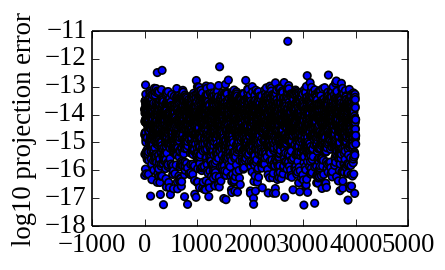

In [11]:
#### Error check ####

TS_rand_size = 4000

TS_rand = np.zeros(TS_rand_size*len(ts)).reshape(TS_rand_size, len(ts)) # Allocate random training space

phi0s_rand = np.random.rand(TS_rand_size)*(2.*np.pi)
psis_rand = np.random.rand(TS_rand_size)*(np.pi/2.)-(np.pi/4.)
cosis_rand = np.random.rand(TS_rand_size)*2. - 1.
f0s_rand = np.random.rand(TS_rand_size)*df0-(df0/2.)
f1s_rand = np.random.rand(TS_rand_size)*df1-(df1/2.)

for i in range(TS_rand_size):
  TS_rand[i] = signalmodel(ts, h0, cosis_rand[i], phi0s_rand[i], f0s_rand[i], f1s_rand[i], psis_rand[i], FAs, FBs)
  # normalize
  TS_rand[i] /= np.sqrt(abs(dot_product(dt, TS_rand[i], TS_rand[i])))


### find projection errors ###
iter = 0
proj_rand = np.zeros(len(ts))
proj_error = []

for h in TS_rand:
  while iter < len(RB_matrix):
    proj_coefficients_rand = dot_product(dt, RB_matrix[iter], h)
    proj_rand += proj_coefficients_rand*RB_matrix[iter]

    iter += 1

  residual = h - proj_rand
  projection_errors = abs(dot_product(dt, residual, residual))
  proj_error.append(projection_errors)
  proj_rand = np.zeros(len(ts))

  iter = 0
        
plt.scatter(np.linspace(0, len(proj_error), len(proj_error)), np.log10(proj_error))
plt.ylabel('log10 projection error')
plt.show()

In [12]:
# put basis into complex form
e = np.array(RB_matrix)

indices = []
ts_nodes = []
V = np.zeros((len(e), len(e)))

In [13]:
from scipy.linalg import inv

# seed EIM algorithm

indices.append( int(np.argmax( np.abs(e[0]) )) ) # (2) of Algorithm 2
ts_nodes.append(ts[indices]) # (3) of Algorithm 2

for i in range(1, len(e)): #(4) of Algorithm 2
  #build empirical interpolant for e_iter
  for j in range(len(indices)): # Part of (5) of Algorithm 2: making V_{ij} 
    for k in range(len(indices)): # Part of (5) of Algorithm 2: making V_{ij} 
      V[k][j] = e[j][indices[k]] # Part of (5) of Algorithm 2: making V_{ij} 
  invV = inv(V[0:len(indices), 0:len(indices)]) # Part of (5) of Algorithm 2: making V_{ij} 
  B = B_matrix(invV, e) # Part of (5) of Algorithm 2: making B_j(f)
  interpolant = emp_interp(B, e[i], indices) # Part of (5) of Algorithm 2: making the empirical interpolant of e
  res = interpolant - e[i] # 6 of Algorithm 2

  index = int(np.argmax(np.abs(res))) # 7 of Algorithm 2
  print "F_{%i} = %f"%(i, ts[index])
  indices.append(index) # 8 of Algorithm 2
  ts_nodes.append( ts[index] ) # 9 of Algorithm 2
        
# make B matrix with all the indices
for j in range(len(indices)):
  for k in range(len(indices)):
    V[k][j] = e[j][indices[k]]

invV = inv(V[0:len(indices), 0:len(indices)])
B = B_matrix(invV, e)

F_{1} = 41548.853370
F_{2} = 38486.726894
F_{3} = 36985.684503
F_{4} = 38967.060459
F_{5} = 40888.394719
F_{6} = 42149.270327
F_{7} = 40107.852675
F_{8} = 43169.979152
F_{9} = 44070.604587
F_{10} = 44490.896456
F_{11} = 7565.253648
F_{12} = 1921.334260
F_{13} = 35964.975678
F_{14} = 42629.603892
F_{15} = 51996.108409
F_{16} = 39507.435719
F_{17} = 3062.126477
F_{18} = 14710.215427
F_{19} = 34704.100069
F_{20} = 45031.271716
F_{21} = 48573.731758
F_{22} = 10687.421821
F_{23} = 13089.089646
F_{24} = 15190.548992
F_{25} = 11167.755386
F_{26} = 9006.254343
F_{27} = 46292.147325
F_{28} = 16391.382905
F_{29} = 49894.649062
F_{30} = 46652.397498
F_{31} = 40468.102849
F_{32} = 8045.587213
F_{33} = 51215.566366
F_{34} = 49054.065323
F_{35} = 50314.940931
F_{36} = 43590.271022
F_{37} = 41248.644892
F_{38} = 6424.461432
F_{39} = 10026.963169
F_{40} = 47012.647672
F_{41} = 54637.943016
F_{42} = 12128.422516
F_{43} = 9546.629604
F_{44} = 48153.439889
F_{45} = 17532.175122
F_{46} = 4323.002085
F_{47

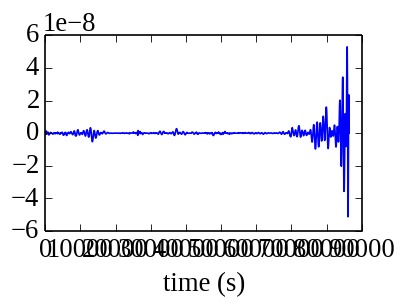

In [14]:
h_for_comparison = signalmodel(ts, h0, cosis[0], phi0s[0], f0s[0], f1s[0], psis[0], FAs, FBs)
interpolant_for_comparison = np.inner(B.T, h_for_comparison[indices])

plt.plot(ts, h_for_comparison-interpolant_for_comparison, 'b')
plt.xlabel('time (s)')
plt.show()

In [15]:
print len(ts_nodes)
print len(ts)

203
1440


7.34947601781e-31
1.33191650715e-12
5.58738333357e-14
1.52881705876e-14
1.8153100489e-14
7.04016333462e-13
1.84019956538e-13
5.1190762297e-14
1.26521389941e-14
4.73980748334e-16
4.32537684702e-15
3.1692527182e-13
1.33182387001e-15
2.67257954869e-14
4.15815467991e-16
1.37721132083e-12
5.521473623e-14
4.56300469877e-14
1.02070519274e-14
3.50794962567e-14
1.44438507485e-13
5.21680179479e-15
7.58186327454e-14
2.02568901904e-15
1.01636333213e-14
3.81458605689e-14
7.36498005274e-14
4.18054311237e-14
9.37260333067e-14
1.4863073522e-13
2.81944185137e-13
4.41638030272e-15
1.62333247456e-12
8.66334365738e-14
9.46400904283e-13
4.05191869378e-30
1.72191647342e-14
1.09188110024e-15
1.52209883161e-14
7.73165205015e-15
8.8229599811e-13
6.87431072069e-14
8.07792909337e-16
5.1664921274e-15
4.13249253795e-14
1.76812074747e-13
2.33929895709e-13
2.08758389891e-13
1.26383202433e-14
1.03717333705e-13
7.21305250894e-30
1.43998058563e-14
4.40796772471e-13
2.9211883156e-13
6.46281431049e-16
9.85714538577e-14
8

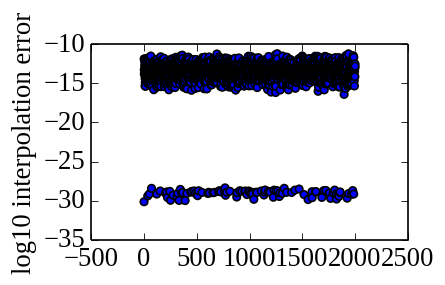

In [16]:
H_size = 2000

H = np.zeros(H_size*len(ts)).reshape(H_size, len(ts)) # Allocate random training space

f0s_rand = np.random.rand(H_size)*df0-(df0/2.)
f1s_rand = np.random.rand(H_size)*df1-(df1/2.)
phi0s_rand = np.random.rand(H_size)*(2.*np.pi)
psis_rand = np.random.rand(H_size)*(np.pi/2.)-(np.pi/4.)
cosis_rand = np.random.rand(H_size)*2. - 1.

# create set of test waveforms
for i in range(H_size):
  H[i] = signalmodel(ts, h0, cosis[i], phi0s[i], f0s[i], f1s[i], psis[i], FAs, FBs)

# find errors between full waveform and interpolants
list_of_errors = []
for i in range(H_size):
  interpolant = np.inner(B.T, H[i][indices])
  interpolant /= np.sqrt(np.vdot(interpolant, interpolant)) #normalize

  H[i] /= np.sqrt(np.vdot(H[i], H[i]) ) #normalize
        
  error = abs(np.vdot(H[i] - interpolant, H[i] - interpolant ))
  list_of_errors.append(error)

  print error
        
plt.scatter(np.linspace(0, H_size, H_size), np.log10(list_of_errors))
plt.ylabel('log10 interpolation error')
plt.show()